# Code to Make FS Subfield Images

The function below is used to make qc images for different segmentations produced by freesurfer. It will only work for images that are in FreeSurfer's padded voxel space (256,256,256) (which is most FreeSurfer images). Below the code, you can see some example output. The prerequisite packages are matplotlib, numpy, os, and nibabel. Except for nibabel, you should likely have these packages installed. nibabel can be installed even on systems where you do not have root by using the command "pip install --user nibabel" in the command line (at least at MSI). As mentioned below, you will need to update the path to your FreeSurfer intall's color lut file.

When you run this script, this will create a new folder in your subject's stats folder named qc_images, and the resulting images will be saved there.

In [21]:
import matplotlib.patches as mpatches
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os



def make_fs_qc_images(subj_path, list_of_overlays, ap_buffer_size = 3, crop_buffer=20, num_total_images=16):
    
    #NEW USERS: BEFORE USING THIS FUNCTION, UPDATE THE PATH "path_to_fs_color_lut" TO POINT
    #TO THE COLOR LUT FILE FOUND IN YOUR FREESURFER INSTALLATION DIRECTORY (see load_color_lut
    #dictionary function below)
    
    #This is a script to make qc images for different freesurfer segmentions,
    #made with the subcortical subfield segmentations in mind (but it will probably work
    #for other aseg type volumes found under the subject's fs mri folder as well). Inputs include
    #(1) subj_path which is the path to the subject who you want to make a qc image
    #for, (2) list_of_overlays which is a list of images whose contents will be
    #summed to produce the overlay file that will be projected on top of the T1 from freesurfer.
    #The reason why this is a list is because sometimes subcortical segmentations produce seperate
    #lh/rh files... if you only have one file, you still need to put it in a list.
    #This assumes the overlays are under the subject's mri folder, so if that is not the case
    #you will need to jimmy rig the script. Some example overlay option lists include:
    #
    # ['ThalamicNuclei.v10.T1.FSvoxelSpace.mgz']
    # ['brainstemSsLabels.v12.FSvoxelSpace.mgz']
    # ['rh.hippoAmygLabels-T1.v21.HBT.FSvoxelSpace.mgz','lh.hippoAmygLabels-T1.v21.HBT.FSvoxelSpace.mgz']
    #
    #(3) ap_buffer_size is the number of anterior/posterior slices (on each side) that
    #will be included in the partition to determine where the slices begin/end. If equal
    #to zero, this will be the bounds determined from the overlay. (4) crop_buffer is the number of voxels beyond
    #the bounds of the overlay to be included for the in-plane dimensions (l/r and inf/sup).
    #(5) num_total_images can be between 4 and 49 any number that has a square root that is an integer.
    #This will be the total number of images included in the panel.
    #
    #subj_path and list_of_overlays are the only required arguments. If you don't want to include
    #any sort of cropping, you can just set the related variables to 255+, and then the images will
    #be made with all voxels for each panel image
    #
    #The output of the script will be images of the overlay on top of the anatomical image in the
    #color scheme described by the freesurfer color lut file (update the path to the color lut
    #in this script if necessary). The images will be saved in a new folder under /subject/stats/
    #named qc_images.
    
    
    
    #Script to load the freesurfer color lut file as a dictionary.
    #This file can be found in your $FREESURFER_HOME directory.
    def load_color_lut_dictionary():
    
        path_to_fs_color_lut = '/home/svinogra/shared/imaging/resources_and_software/freesurfer/FreeSurferColorLUT.txt'

        color_lut_file = open(path_to_fs_color_lut,'r')
        color_lut_dictionary = {}
        for line in color_lut_file:
            if line[0].isnumeric():

                split_line = line.split(' ')
                reduced_line = list(filter(lambda a: a != '', split_line))
                reduced_line[-1] = reduced_line[-1].strip('\n')
                key = int(reduced_line[0])
                color = [float(reduced_line[2])/256,float(reduced_line[3])/256,float(reduced_line[4])/256,1]
                anat = reduced_line[1]
                color_lut_dictionary[key] = [anat, color]

        return color_lut_dictionary
  
    lut_dict = load_color_lut_dictionary()
    
    t1_path = os.path.join(subj_path,"mri/T1.mgz")
    t1_obj = nib.load(t1_path)
    t1_data = t1_obj.get_data()
    
    print(t1_data.shape)

    overlay_data = np.zeros((t1_data.shape))
    for temp_overlay in list_of_overlays:

        overlay_obj = nib.load(os.path.join(subj_path,'mri',temp_overlay))
        overlay_data += overlay_obj.get_data()
        
    
    overlay_ap_max = np.max(overlay_data,axis=(0,1))
    non_zero_locations = np.where(overlay_ap_max > 0.5)[0]
    min_lim = np.min(non_zero_locations) - ap_buffer_size
    if min_lim < 0:
        min_lim = 0
    max_lim = np.max(non_zero_locations) + ap_buffer_size
    if max_lim > 254:
        max_lim = 254
    inds_to_capture = np.linspace(min_lim,max_lim,num_total_images,dtype=int)
    
    overlay_max_0 = np.max(overlay_data,axis=(1,2))
    overlay_max_1 = np.max(overlay_data,axis=(0,2))
    overlay_locations_0 = np.where(overlay_max_0 > 0.5)[0]
    overlay_locations_1 = np.where(overlay_max_1 > 0.5)[0]
    min0 = np.min(overlay_locations_0) - crop_buffer
    if min0 < 0:
        min0 = 0
    max0 = np.max(overlay_locations_0) + crop_buffer
    if max0 > 254:
        max0 = 254
    min1 = np.min(overlay_locations_1) - crop_buffer
    if min1 < 0:
        min1 = 0
    max1 = np.max(overlay_locations_1) + crop_buffer
    if max1 > 254:
        max1 = 254
        
    
    num_imgs_per_dim = int(np.sqrt(num_total_images))
    counting_index = 0
    for i in range(num_imgs_per_dim):            
            
        temp_t1_row = t1_data[min0:max0,min1:max1,inds_to_capture[counting_index]]
        temp_overlay_row = overlay_data[min0:max0,min1:max1,inds_to_capture[counting_index]]
        counting_index += 1
        for j in range(1,num_imgs_per_dim):
            temp_t1_row = np.vstack((temp_t1_row,t1_data[min0:max0,min1:max1,inds_to_capture[counting_index]]))
            temp_overlay_row = np.vstack((temp_overlay_row,overlay_data[min0:max0,min1:max1,inds_to_capture[counting_index]]))
            counting_index +=1
        if i == 0:
            temp_t1_full = temp_t1_row
            temp_overlay_full = temp_overlay_row
        else:
            temp_t1_full = np.hstack((temp_t1_full,temp_t1_row))
            temp_overlay_full = np.hstack((temp_overlay_full,temp_overlay_row))

    t1_panel = np.fliplr(np.rot90(temp_t1_full,3))
    overlay_panel = np.fliplr(np.rot90(temp_overlay_full,3))
    unique_values = np.unique(overlay_panel)[1:]

    overlay_panel_4d = np.zeros((overlay_panel.shape[0],overlay_panel.shape[1],4))
    for i in range(overlay_panel_4d.shape[0]):
        for j in range(overlay_panel_4d.shape[1]):
            if overlay_panel[i,j] < 0.5:
                continue
            else:
                overlay_panel_4d[i,j,:] = lut_dict[overlay_panel[i,j]][1]
        
    
    
    plt.figure(dpi=400)
    plt.imshow(t1_panel,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    im = plt.imshow(overlay_panel_4d)

    values = unique_values
    colors = [ im.cmap(im.norm(value)) for value in values]
    colors = np.zeros((unique_values.shape[0],4))
    labels = []
    for i in range(unique_values.shape[0]):
        colors[i,:] = lut_dict[values[i]][1]
        labels.append(lut_dict[values[i]][0])



    # create some data
    #data = np.random.randint(0, 8, (5,5))
    # get the unique values from data
    # i.e. a sorted list of all values in data
    patches = [ mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(values)) ]

    if len(values) > 25:
        plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize ='xx-small',ncol=2)
    else:
        plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize ='xx-small')
    
    qc_images_folder = os.path.join(subj_path,'stats','qc_images')
    if os.path.exists(qc_images_folder) == False:
        os.mkdir(qc_images_folder)
        
    output_file_name = list_of_overlays[0]
    if output_file_name[1:3] == 'h.':
        output_file_name = output_file_name[3:]
    output_file_name = 'qc_img_' + ''.join(output_file_name.split('.')[:-1]) + '.png'
    
    
    full_img_path = os.path.join(qc_images_folder, output_file_name)
        
    plt.savefig(full_img_path, bbox_inches='tight')

# Example: Thalamic Nuclei (default settings)

(256, 256, 256)


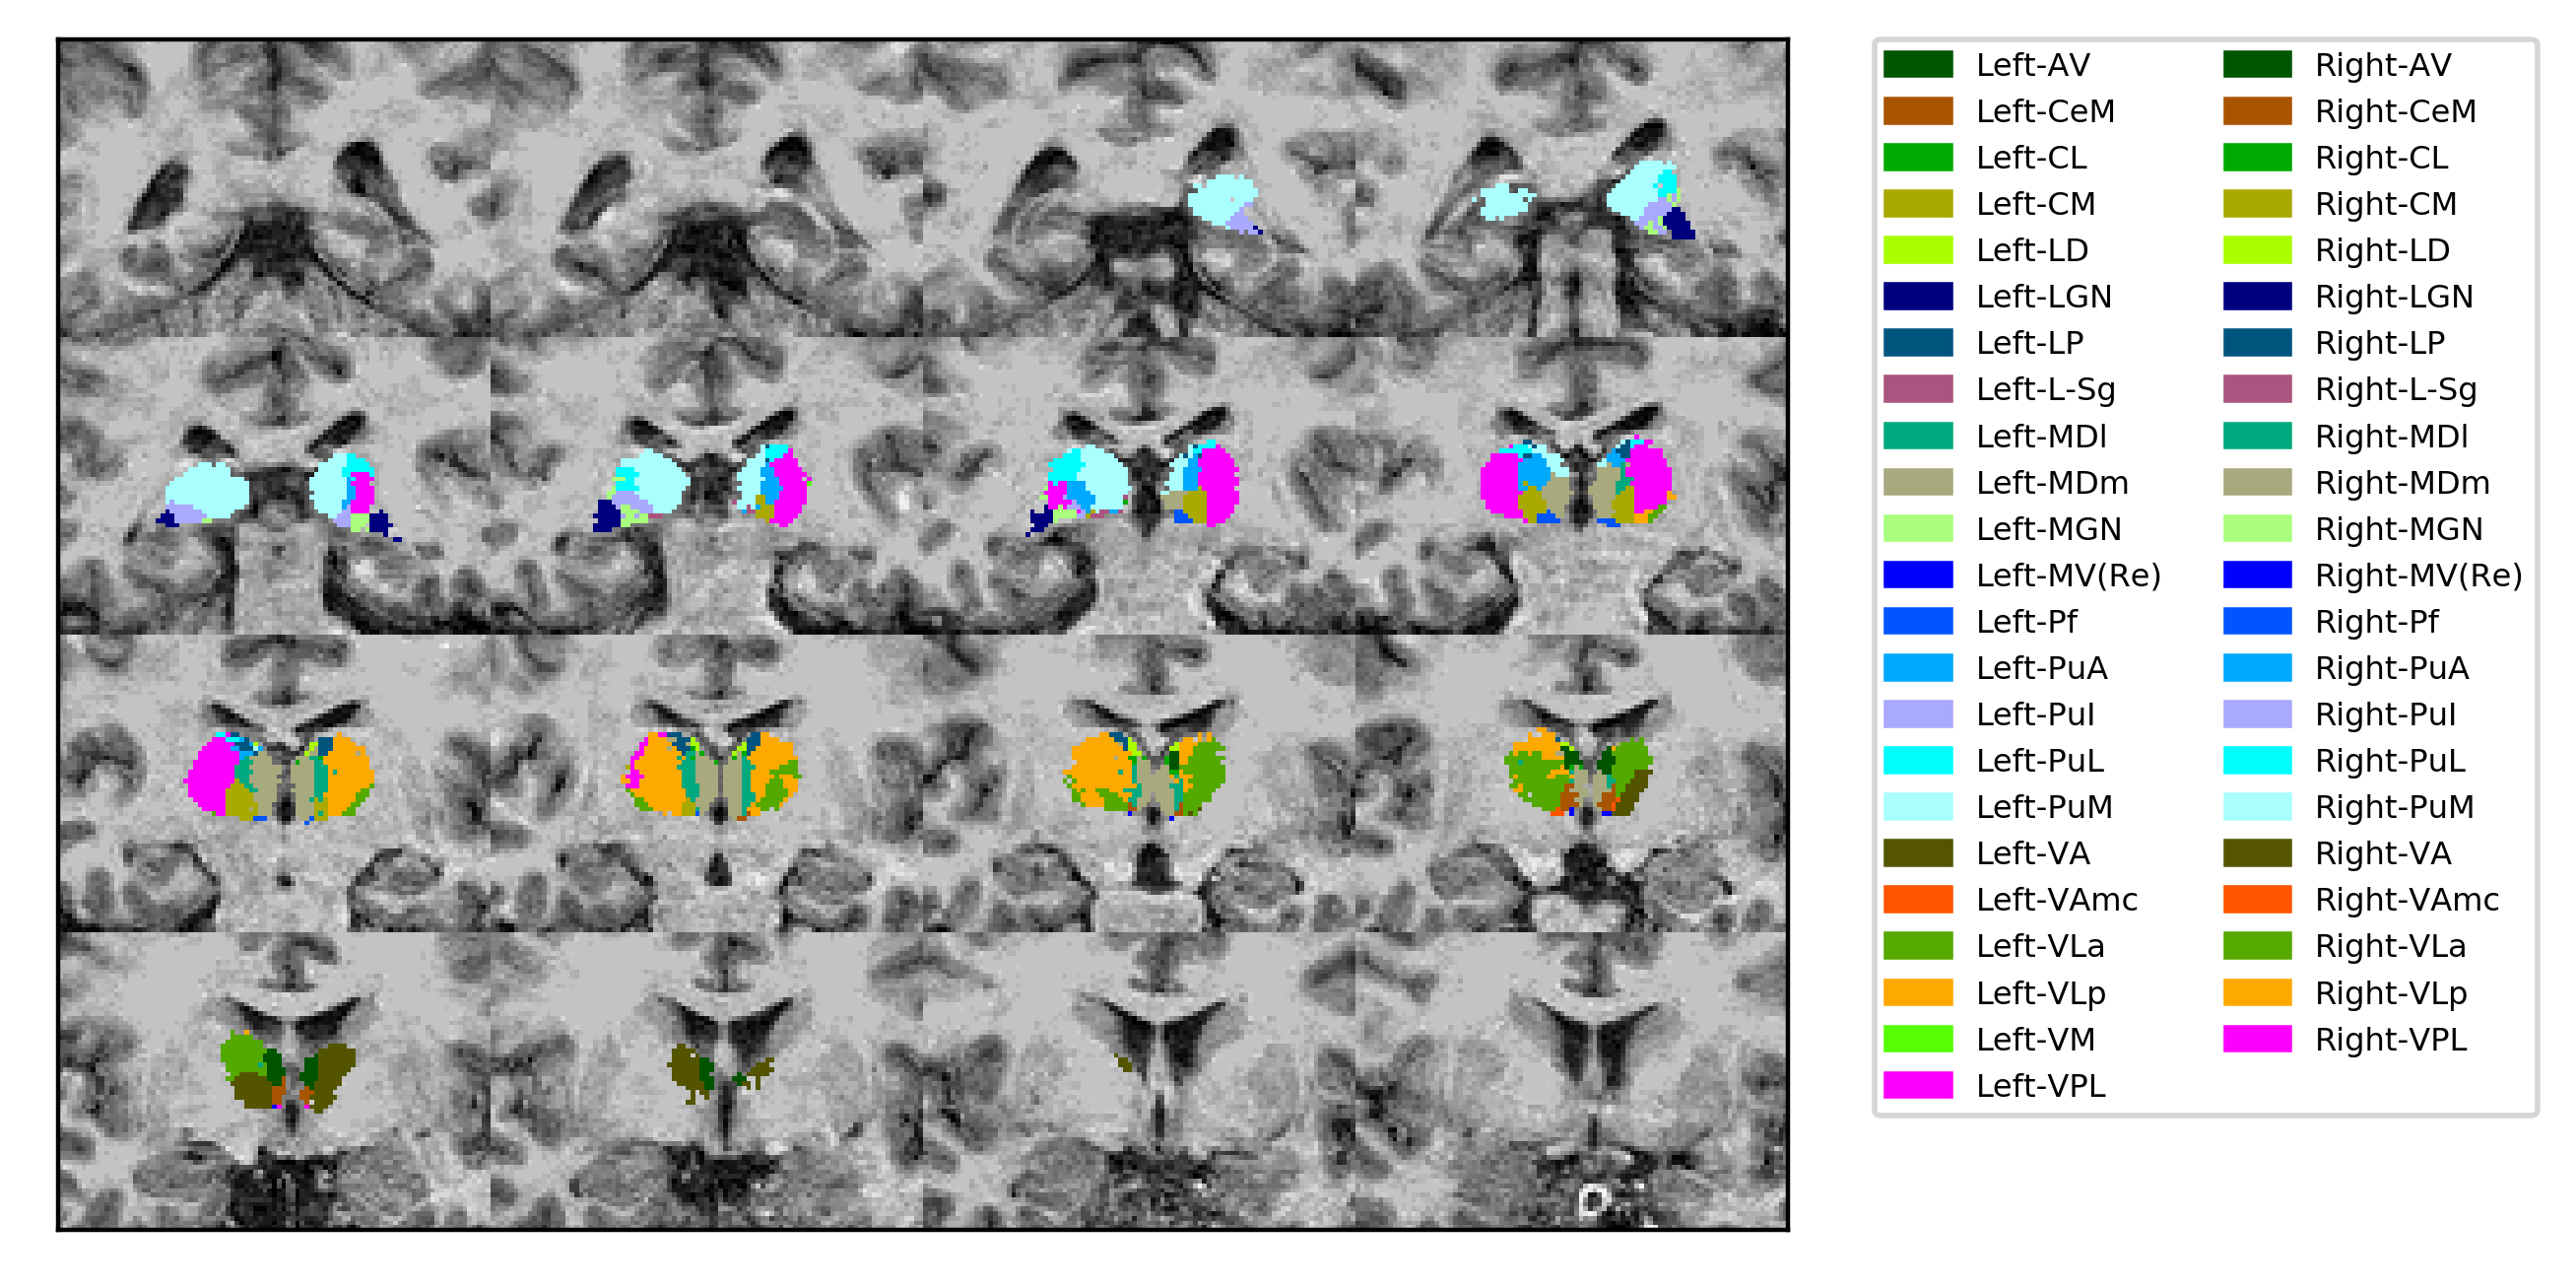

In [20]:
subj_path = '/home/svinogra/leex6144/sub-10159/'
list_of_overlays = ['ThalamicNuclei.v10.T1.FSvoxelSpace.mgz']
make_fs_qc_images(subj_path, list_of_overlays)

# Example: Hippocampal/Amygdala Labels (default settings)

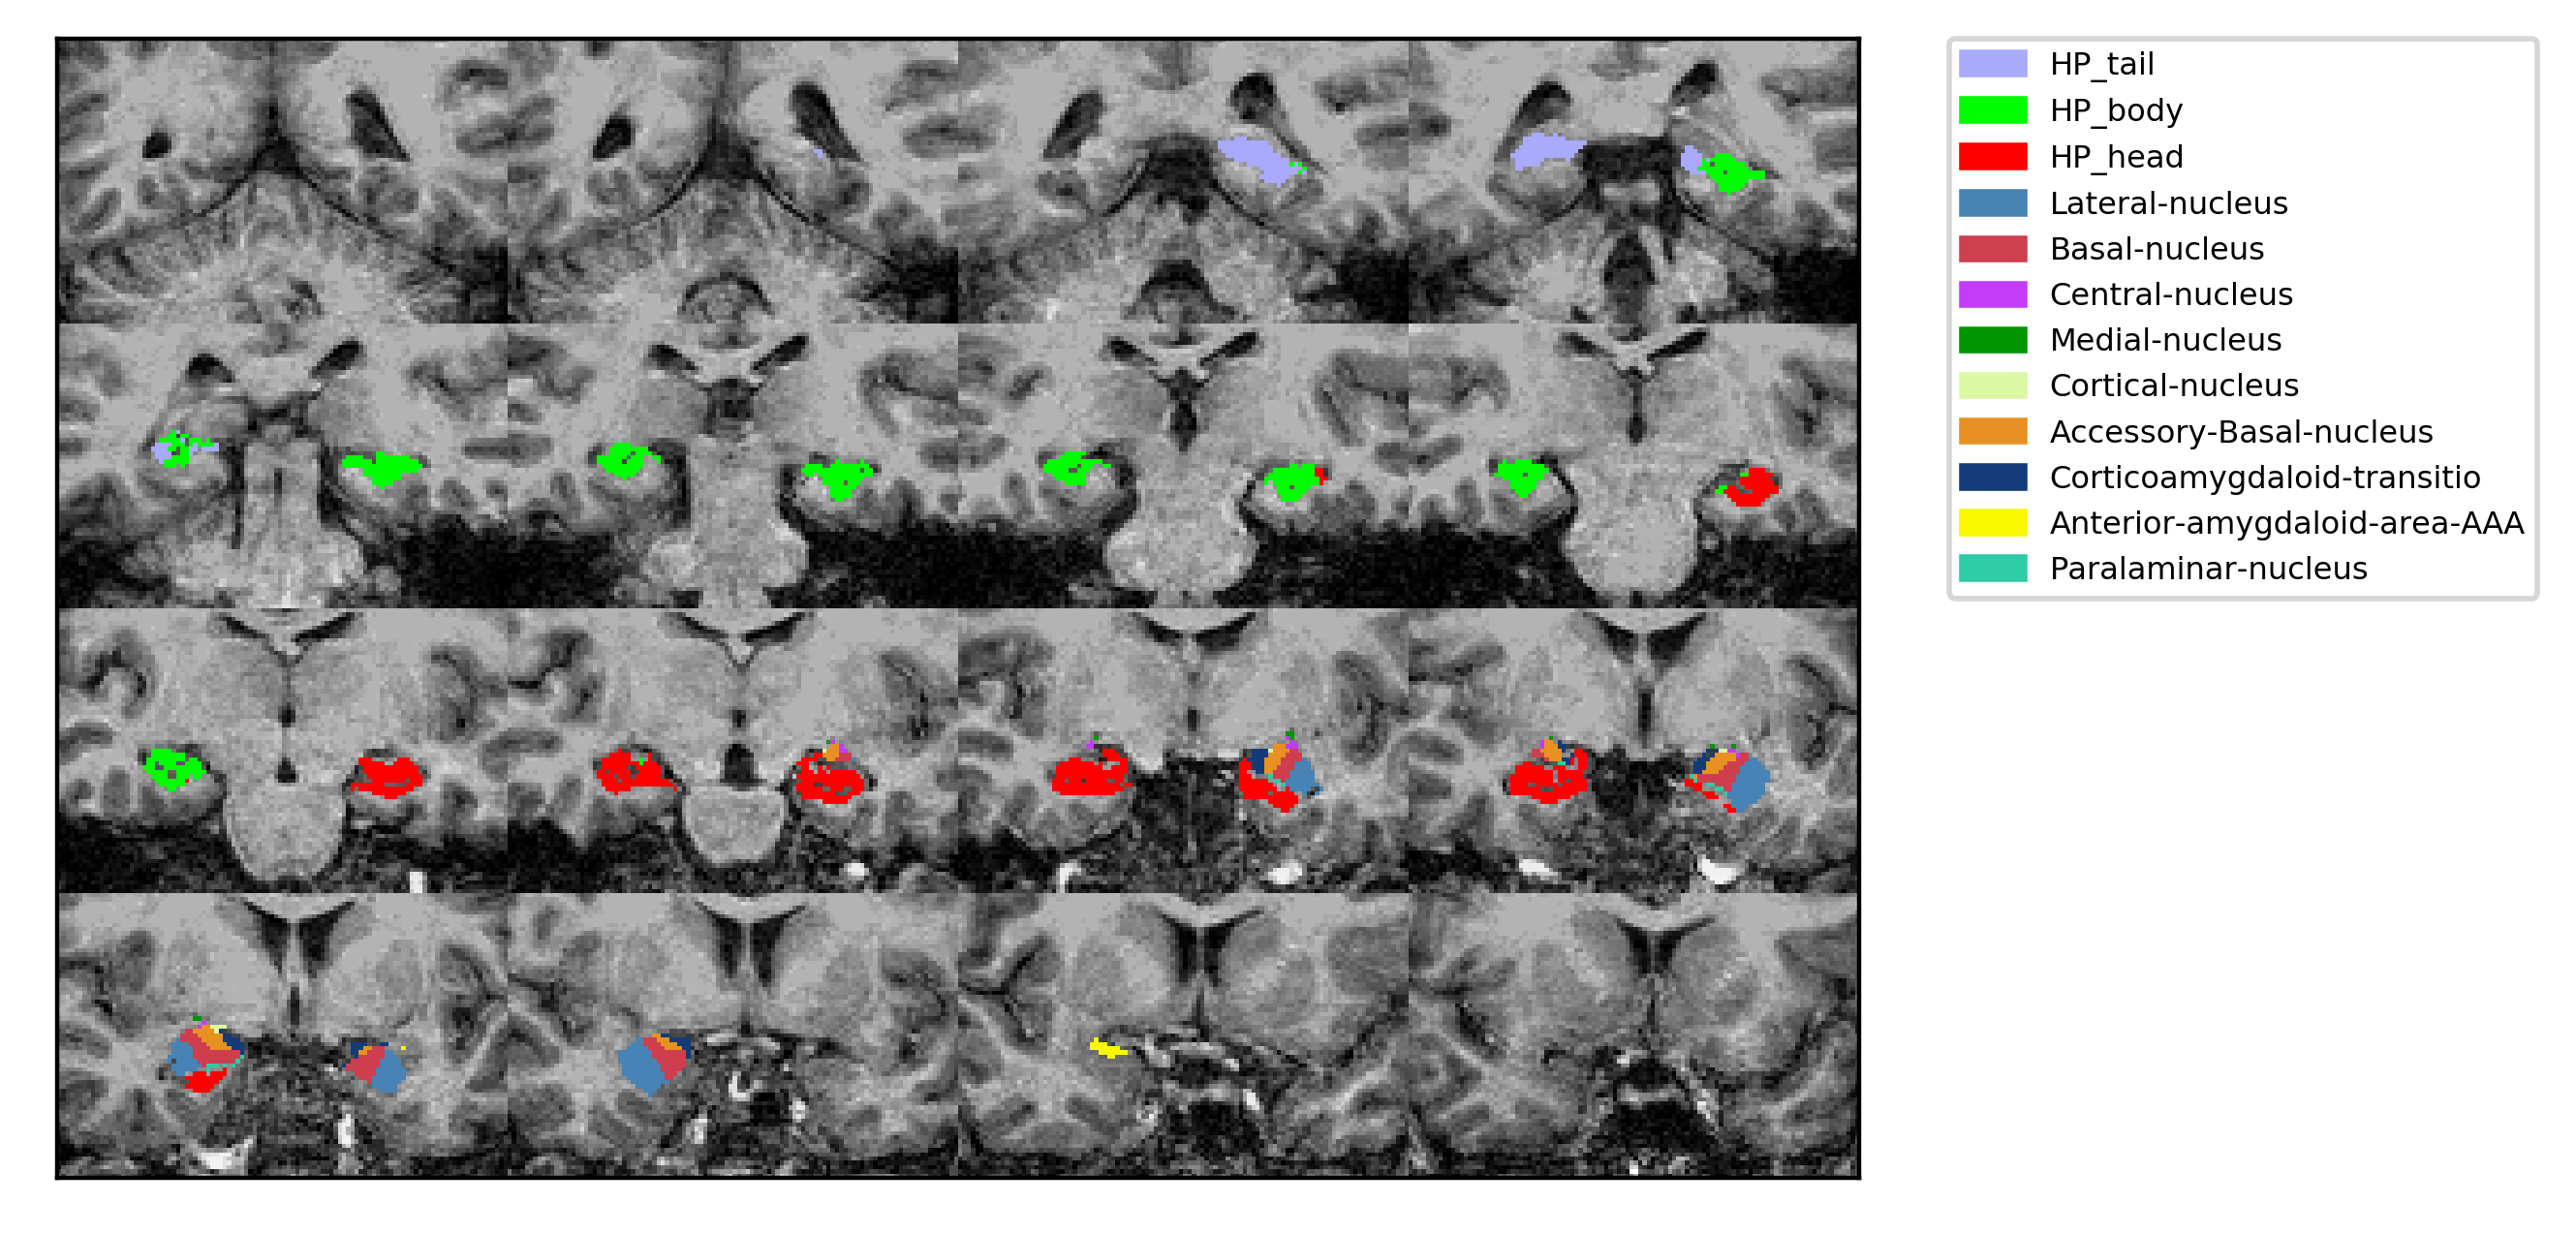

In [17]:
subj_path = '/home/svinogra/leex6144/sub-10159/'
list_of_overlays = ['rh.hippoAmygLabels-T1.v21.HBT.FSvoxelSpace.mgz','lh.hippoAmygLabels-T1.v21.HBT.FSvoxelSpace.mgz']
make_fs_qc_images(subj_path, list_of_overlays)

# Example: Hippocampal/Amygdala Labels (less padding, more images)

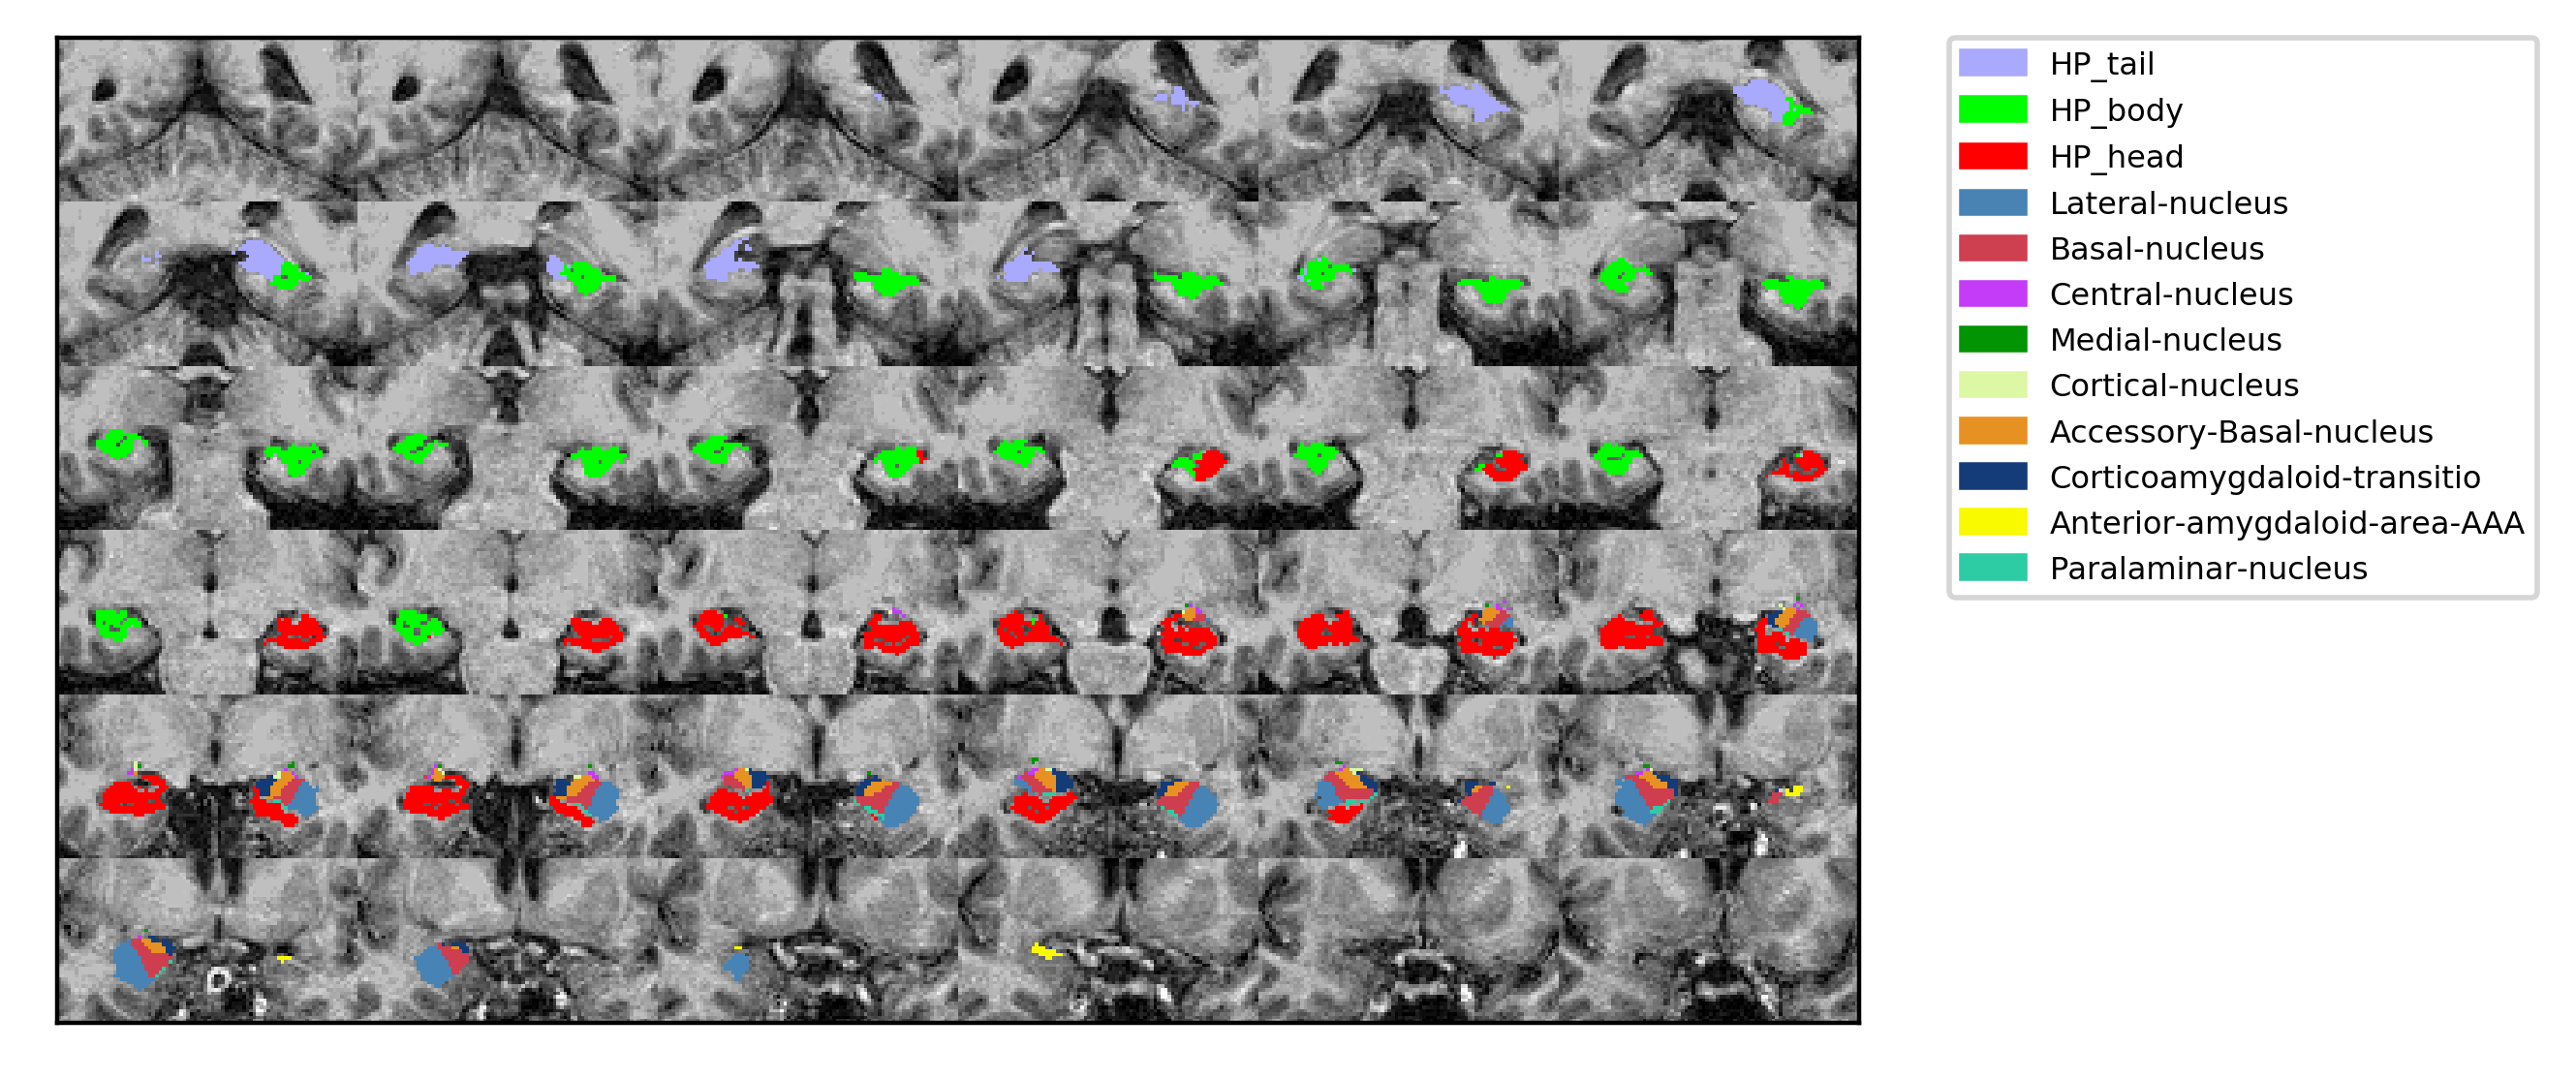

In [18]:
subj_path = '/home/svinogra/leex6144/sub-10159/'
list_of_overlays = ['rh.hippoAmygLabels-T1.v21.HBT.FSvoxelSpace.mgz','lh.hippoAmygLabels-T1.v21.HBT.FSvoxelSpace.mgz']
make_fs_qc_images(subj_path, list_of_overlays, num_total_images=36, crop_buffer=10)